
# Active Region Classification

#### Import Packages

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from collections import OrderedDict as od
from glob import glob
from os.path import basename
from numpy import *
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.model_selection import validation_curve
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import ShuffleSplit
from sklearn import model_selection
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### CSV Dataset Path

In [2]:
path = %pwd
ARdataCSVlistI= glob(path + "/solarFlareDataset1/*.csv")
ARdataCSVlistII = glob(path + "/solarFlareDataset2/*.csv")
ARdataCSVlistIII = glob(path + "/solarFlareDataset3/*.csv")
ARdataCSVlistIV = glob(path + "/solarFlareDataset4/*.csv")

In [3]:
print path

/Users/ankush/test/ADM


In [4]:
labeled_key_index=['event_type',
        'event_year',
        'event_month',
        'event_day',
        'event_hour',
        'event_minute',
        'lookback_hours',
        'span_hours',
        'flare_class']

In [5]:
def parseARdata(ARdataCSVlist):
    ar_data = od()
    for ARdataCSV in ARdataCSVlist:
        CSVbaseName = basename(ARdataCSV)
        event_type_code = CSVbaseName[0]
        event_type = CSVbaseName[0:5] if event_type_code == 'f' else CSVbaseName[0:7]
        event_year = int(CSVbaseName[5:9] if event_type_code == 'f' else CSVbaseName[7:11])
        event_month = int(CSVbaseName[10:12] if event_type_code == 'f' else CSVbaseName[12:14])
        event_day = int(CSVbaseName[13:15] if event_type_code == 'f' else CSVbaseName[15:17])
        event_hour = int(CSVbaseName[16:18] if event_type_code == 'f' else CSVbaseName[18:20])
        event_minute = int(CSVbaseName[19:21] if event_type_code == 'f' else CSVbaseName[21:23])
        lookback_hours = int(CSVbaseName[26:28] if event_type_code == 'f' else CSVbaseName[28:30])
        span_hours = CSVbaseName[32:34] if event_type_code == 'f' else CSVbaseName[34:36]
        span_hours = int(span_hours[0] if span_hours[0] == '6' else span_hours)
        flare_class = CSVbaseName[-5:-4]
        ar_data[
            event_type,
            event_year,
            event_month,
            event_day,
            event_hour,
            event_minute,
            lookback_hours,
            span_hours,
            flare_class] = pd.read_csv(ARdataCSV,index_col=0,parse_dates=['TimeStamp'])
    return ar_data

In [6]:
unlabeled_key_index=['event_id',
        'lookback_hours',
        'span_hours']

##### Parse each time series to a pandas DataFrame

In [7]:
def parseUnlabeledARdata(ARdataCSVlist):
    ar_data = od()
    for ARdataCSV in ARdataCSVlistIV:
        CSVbaseName = basename(ARdataCSV)
        event_type_code = CSVbaseName[0]
        span_hours = 6 if CSVbaseName[:-4][-2:]=='n6' else CSVbaseName[:-4][-2:]
        lookback_hours = CSVbaseName[:-9][-2:] if span_hours==6 else CSVbaseName[:-10][-2:]
        event_id = CSVbaseName[:-16] if span_hours==6 else CSVbaseName[:-17]
        ar_data[int(event_id),
                int(lookback_hours),
                int(span_hours)] = pd.read_csv(ARdataCSV,index_col=0,parse_dates=['TimeStamp'])
    return ar_data

##### Load all time series in an ordered dictionary ar_data

In [8]:
ar_dataI = parseARdata(ARdataCSVlistI)

In [9]:
ar_dataII = parseARdata(ARdataCSVlistII)

In [10]:
ar_dataIII = parseARdata(ARdataCSVlistIII)

In [11]:
ar_dataIV = parseUnlabeledARdata(ARdataCSVlistIV)

#### Sampling Data based on extraction windows

In [12]:
def sampling(ar_data,key_index):
    dd=pd.DataFrame(ar_data.keys(), columns=key_index)
    d=pd.DataFrame()
    d.l12_s6=dd.query('lookback_hours==12 and span_hours==6')

    d.l12_s12=dd.query('lookback_hours==12 and span_hours==12')

    d.l12_s24=dd.query('lookback_hours==12 and span_hours==24')

    d.l24_s6=dd.query('lookback_hours==24 and span_hours==6')

    d.l24_s12=dd.query('lookback_hours==24 and span_hours==12')

    d.l24_s24=dd.query('lookback_hours==24 and span_hours==24')
    
    return d

In [13]:
def printDatasetLen(dd):
    print u'Total Events :' + str(len(dd.l12_s6)+len(dd.l12_s12)+len(dd.l12_s24)+len(dd.l24_s6)+len(dd.l24_s12)+len(dd.l24_s24))
    print u'Total ' + str(len(dd.l12_s6)) + u' in Lookback 12 Span 6'
    print u'Total ' + str(len(dd.l12_s12)) + u' in Lookback 12 Span 12'
    print u'Total ' + str(len(dd.l12_s24)) + u' in Lookback 12 Span 24'
    print u'Total ' + str(len(dd.l24_s6)) + u' in Lookback 24 Span 6'
    print u'Total ' + str(len(dd.l24_s12)) + u' in Lookback 24 Span 12'
    print u'Total ' + str(len(dd.l24_s24)) + u' in Lookback 24 Span 24'

##### TimeSeries Key stored in a DataFrame

In [14]:
ddI=sampling(ar_dataI,labeled_key_index)
ddII=sampling(ar_dataII,labeled_key_index)
ddIII=sampling(ar_dataIII,labeled_key_index)
ddIV=sampling(ar_dataIV,unlabeled_key_index)

In [15]:
printDatasetLen(ddI)
print('Dataset I\n')
printDatasetLen(ddII)
print('Dataset II\n')
printDatasetLen(ddIII)
print('Dataset III\n')
printDatasetLen(ddIV)
print('Dataset IV\n')

Total Events :106
Total 18 in Lookback 12 Span 6
Total 18 in Lookback 12 Span 12
Total 18 in Lookback 12 Span 24
Total 18 in Lookback 24 Span 6
Total 18 in Lookback 24 Span 12
Total 16 in Lookback 24 Span 24
Dataset I

Total Events :2544
Total 444 in Lookback 12 Span 6
Total 432 in Lookback 12 Span 12
Total 418 in Lookback 12 Span 24
Total 428 in Lookback 24 Span 6
Total 420 in Lookback 24 Span 12
Total 402 in Lookback 24 Span 24
Dataset II

Total Events :2435
Total 433 in Lookback 12 Span 6
Total 417 in Lookback 12 Span 12
Total 400 in Lookback 12 Span 24
Total 407 in Lookback 24 Span 6
Total 401 in Lookback 24 Span 12
Total 377 in Lookback 24 Span 24
Dataset III

Total Events :2480
Total 430 in Lookback 12 Span 6
Total 420 in Lookback 12 Span 12
Total 410 in Lookback 12 Span 24
Total 420 in Lookback 24 Span 6
Total 412 in Lookback 24 Span 12
Total 388 in Lookback 24 Span 24
Dataset IV



#### Extract Labels
- noflare => 0
- flare => 1

In [16]:
fx = lambda x: 1 if x=='flare' else 0
def extractLabels(dd):
    labels = pd.DataFrame()
    labels.l12_s6 = dd.l12_s6['event_type'].apply(fx)
    labels.l12_s12 = dd.l12_s12['event_type'].apply(fx)
    labels.l12_s24 = dd.l12_s24['event_type'].apply(fx)
    labels.l24_s6 = dd.l24_s6['event_type'].apply(fx)
    labels.l24_s12 = dd.l24_s12['event_type'].apply(fx)
    labels.l24_s24 = dd.l24_s24['event_type'].apply(fx)
    return labels

In [17]:
yI=extractLabels(ddI)
yII=extractLabels(ddII)
yIII=extractLabels(ddIII)

##### Extract Raw Feature Names

In [18]:
featI=ar_dataI.items()[0][1].columns
featII=ar_dataII.items()[0][1].columns
featIII=ar_dataIII.items()[0][1].columns
featIV=ar_dataIII.items()[0][1].columns

#### Plotting raw features grouped with event extraction windows

In [19]:
def plotFeat(ar_data,feature,dd):
    spans = [6,12,24]
    lookbacks = [12,24]

    event_col = 0
    prior_col = -3
    span_col = -2
    event_type = ['flare','noflare']

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

    for ax, span in zip(axes[0], spans):
        ax.set_title("Span "+str(span))

    for ax, lookback in zip(axes[:,0], lookbacks):
        ax.set_ylabel("Lookback "+str(lookback), rotation=90, size='large')

    for lookback in lookbacks:
        if lookback==12:
            for ax, span in zip(axes[0], spans):
                if span==6:
                    for key in dd.l12_s6.values:
                        df=ar_data[key[0],key[1],key[2],key[3],key[4],key[5], key[6], key[7], key[8]]
                        if key[0]=='flare':
                            if key[8]=='X':
                                ax.plot(list(df[feature]),'Blue',label='Flare_X',linewidth=2.5, linestyle="--")
                            elif key[8]=='M':
                                ax.plot(list(df[feature]),'Cyan',label='Flare_M',linewidth=2.5, linestyle="-")
                        elif key[0]=='noflare':
                            ax.plot(list(df[feature]),'Red',label='noFlare',linewidth=2.5, linestyle="-.")
                elif span==12:
                    for key in dd.l12_s12.values:
                        df=ar_data[key[0],key[1],key[2],key[3],key[4],key[5], key[6], key[7], key[8]]
                        if key[0]=='flare':
                            if key[8]=='X':
                                ax.plot(list(df[feature]),'Blue',label='Flare_X',linewidth=2.5, linestyle="--")
                            elif key[8]=='M':
                                ax.plot(list(df[feature]),'Cyan',label='Flare_M',linewidth=2.5, linestyle="-")
                        elif key[0]=='noflare':
                            ax.plot(list(df[feature]),'Red',label='noFlare',linewidth=2.5, linestyle="-.")
                elif span==24:
                    for key in dd.l12_s24.values:
                        df=ar_data[key[0],key[1],key[2],key[3],key[4],key[5], key[6], key[7], key[8]]
                        if key[0]=='flare':
                            if key[8]=='X':
                                ax.plot(list(df[feature]),'Blue',label='Flare_X',linewidth=2.5, linestyle="--")
                            elif key[8]=='M':
                                ax.plot(list(df[feature]),'Cyan',label='Flare_M',linewidth=2.5, linestyle="-")
                        elif key[0]=='noflare':
                            ax.plot(list(df[feature]),'Red',label='noFlare',linewidth=2.5, linestyle="-.")

        elif lookback==24:
            for ax, span in zip(axes[1], spans):
                if span==6:
                    for key in dd.l24_s6.values:
                        df=ar_data[key[0],key[1],key[2],key[3],key[4],key[5], key[6], key[7], key[8]]
                        if key[0]=='flare':
                            if key[8]=='X':
                                ax.plot(list(df[feature]),'Blue',label='Flare_X',linewidth=2.5, linestyle="--")
                            elif key[8]=='M':
                                ax.plot(list(df[feature]),'Cyan',label='Flare_M',linewidth=2.5, linestyle="-")
                        elif key[0]=='noflare':
                            ax.plot(list(df[feature]),'Red',label='noFlare',linewidth=2.5, linestyle="-.")
                elif span==12:
                    for key in dd.l24_s12.values:
                        df=ar_data[key[0],key[1],key[2],key[3],key[4],key[5], key[6], key[7], key[8]]
                        if key[0]=='flare':
                            if key[8]=='X':
                                ax.plot(list(df[feature]),'Blue',label='Flare_X',linewidth=2.5, linestyle="--")
                            elif key[8]=='M':
                                ax.plot(list(df[feature]),'Cyan',label='Flare_M',linewidth=2.5, linestyle="-")
                        elif key[0]=='noflare':
                            ax.plot(list(df[feature]),'Red',label='noFlare',linewidth=2.5, linestyle="-.")
                elif span==24:
                    for key in dd.l24_s24.values:
                        df=ar_data[key[0],key[1],key[2],key[3],key[4],key[5], key[6], key[7], key[8]]
                        if key[0]=='flare':
                            if key[8]=='X':
                                ax.plot(list(df[feature]),'Blue',label='Flare_X',linewidth=2.5, linestyle="--")
                            elif key[8]=='M':
                                ax.plot(list(df[feature]),'Cyan',label='Flare_M',linewidth=2.5, linestyle="-")
                        elif key[0]=='noflare':
                            ax.plot(list(df[feature]),'Red',label='noFlare',linewidth=2.5, linestyle="-.")
    fig.tight_layout()

    fig.suptitle(feature, fontsize=20, y=0)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = od(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),title="Flare Class",loc="upper center", bbox_to_anchor=(1.5,0.25))

    plt.show()

### Uncomment Below to generate plots

In [23]:
# print 'Dataset I'
# for feat in featI:
#     plotFeat(ar_dataI,feat,ddI)

In [22]:
# print 'Dataset II'
# for feat in featII:
#     plotFeat(ar_dataII,feat,ddII)

In [25]:
# print 'Dataset III'
# for feat in featIII:
#     plotFeat(ar_dataIII,feat,ddIII)

### Data Preprocessing

##### Missing Value Imputation

In [26]:
def countMissingValues(ar_data):
    total=0
    for key in ar_data.keys():
        df=ar_data[key]
        nullCount = count_nonzero(df.isnull().values.ravel())
        total+=nullCount
        if nullCount>10:
            print str(key) + str(nullCount)
    print 'Total Missing points ' + str(total)

In [27]:
def fillMissingValues(ar_data):
    ar_data_fillna=od()
    for key in ar_data.keys():
        ar_data_fillna[key]=ar_data[key].fillna(method='ffill').fillna(method='bfill')
    return ar_data_fillna

In [28]:
print('\n\tDataset 1')
countMissingValues(ar_dataI)
print('\n\tDataset 2')
countMissingValues(ar_dataII)
print('\n\tDataset 3')
countMissingValues(ar_dataIII)
print('\n\tDataset 4')
countMissingValues(ar_dataIV)


	Dataset 1
Total Missing points 22

	Dataset 2
(u'flare', 2013, 2, 17, 15, 45, 24, 24, u'M')414
(u'noflare', 2011, 8, 3, 3, 8, 12, 12, u'M')72
(u'noflare', 2011, 8, 3, 3, 8, 12, 24, u'M')72
(u'noflare', 2011, 8, 3, 3, 8, 12, 6, u'M')72
(u'noflare', 2011, 8, 3, 3, 8, 24, 12, u'M')72
(u'noflare', 2011, 8, 3, 3, 8, 24, 24, u'M')81
(u'noflare', 2011, 8, 3, 3, 8, 24, 6, u'M')72
(u'noflare', 2011, 8, 4, 3, 41, 12, 24, u'M')72
(u'noflare', 2011, 8, 4, 3, 41, 24, 12, u'M')72
(u'noflare', 2011, 8, 4, 3, 41, 24, 24, u'M')72
(u'noflare', 2012, 3, 13, 17, 12, 12, 24, u'M')37
Total Missing points 1601

	Dataset 3
(u'noflare', 2011, 8, 3, 4, 29, 12, 12, u'M')72
(u'noflare', 2011, 8, 3, 4, 29, 12, 24, u'M')72
(u'noflare', 2011, 8, 3, 4, 29, 12, 6, u'M')72
(u'noflare', 2011, 8, 3, 4, 29, 24, 12, u'M')72
(u'noflare', 2011, 8, 3, 4, 29, 24, 24, u'M')81
(u'noflare', 2011, 8, 3, 4, 29, 24, 6, u'M')72
Total Missing points 810

	Dataset 4
(1242, 12, 12)243
(24931, 12, 12)72
(39835, 24, 6)72
(41831, 12, 24)

##### Store in new Ordered Dictionary

In [29]:
ar_dataI_fillna=fillMissingValues(ar_dataI)

In [30]:
ar_dataII_fillna=fillMissingValues(ar_dataII)

In [31]:
ar_dataIII_fillna=fillMissingValues(ar_dataIII)

In [32]:
ar_dataIV_fillna=fillMissingValues(ar_dataIV)

##### Double check for missing values

In [33]:
print('\n\tDataset 1')
countMissingValues(ar_dataI_fillna)
print('\n\tDataset 2')
countMissingValues(ar_dataII_fillna)
print('\n\tDataset 3')
countMissingValues(ar_dataIII_fillna)
print('\n\tDataset 4')
countMissingValues(ar_dataIV_fillna)


	Dataset 1
Total Missing points 0

	Dataset 2
Total Missing points 0

	Dataset 3
Total Missing points 0

	Dataset 4
Total Missing points 0


#### z-Score Normalization of Data

In [34]:
z_score = lambda x: (x-(x.mean())/x.std())
def normalize(ar_data):
    ar_data_z_normal=od()
    for key in ar_data.keys():
        ar_data_z_normal[key]=ar_data[key].apply(z_score)
    return ar_data_z_normal

##### Store in new Ordered Dictionary

In [35]:
ar_dataI_z_normal=normalize(ar_dataI_fillna)

In [36]:
ar_dataII_z_normal=normalize(ar_dataII_fillna)

In [37]:
ar_dataIII_z_normal=normalize(ar_dataIII_fillna)

In [38]:
ar_dataIV_z_normal=normalize(ar_dataIV_fillna)

##### Smoothing TS

In [39]:
def smoothing(df,win):
    return df.rolling(win)

In [40]:
def plotRollingAverages(ar_data_z_normal,dd,feats,fx):
    for key in dd.values:
        for feat in feats:
            print str(feat) +'\t'+ str(key)
            if key[0]=='flare':
                
                df=ar_data_z_normal['flare',key[1],key[2],key[3],key[4],key[5], key[6], key[7], key[8]][feat]
                plt.plot(smoothing(df,2).apply(fx),label='Window Size 2',color='Red')
                plt.plot(smoothing(df,4).apply(fx),label='Window Size 4',color='Maroon')
                plt.plot(smoothing(df,8).apply(fx),label='Window Size 8',color='Pink')
                plt.plot(smoothing(df,16).apply(fx),label='Window Size 16',color='Yellow')
                plt.plot(smoothing(df,32).apply(fx),label='Window Size 32',color='Purple')
                plt.plot(smoothing(df,64).apply(fx),label='Window Size 64',color='Cyan')
                plt.plot(ar_data_z_normal[key[0],key[1],key[2],key[3],key[4],key[5], key[6], key[7], key[8]][feat],label='Original Flare TS',color='Blue')
                
                df=ar_data_z_normal['noflare',key[1],key[2],key[3],key[4],key[5], key[6], key[7], key[8]][feat]
                
                plt.plot(smoothing(df,2).apply(fx),label='Window Size 2',color='Red', linestyle='--')
                plt.plot(smoothing(df,2).apply(fx),label='Window Size 4',color='Maroon', linestyle='--')
                plt.plot(smoothing(df,8).apply(fx),label='Window Size 8',color='Pink', linestyle='--')
                plt.plot(smoothing(df,16).apply(fx),label='Window Size 16',color='Yellow', linestyle='--')
                plt.plot(smoothing(df,32).apply(fx),label='Window Size 32',color='Purple', linestyle='--')
                plt.plot(smoothing(df,64).apply(fx),label='Window Size 64',color='Cyan', linestyle='--')
                plt.plot(df,label='Orginal NoFlare TS',color='Blue', linestyle='--')
                
                plt.legend()
                plt.show()

In [42]:
#plotRollingAverages(ar_dataIII_z_normal,ddIII.l24_s24,featIII,var)

In [43]:
#plotRollingAverages(ar_dataIII_z_normal,ddIII.l12_s12,featIII,kurtosis)

### Feature Set Generation

In [44]:
def featureSet(df):
    ff=pd.DataFrame(data=df.mean()).transpose()
    ff.columns = [str(col) + '_mean' for col in ff.columns]

    sf=pd.DataFrame(data=df.var()).transpose()
    sf.columns = [str(col) + '_var' for col in sf.columns]

    tf=pd.DataFrame(data=df.skew()).transpose()
    tf.columns = [str(col) + '_skew' for col in tf.columns]

    qf=pd.DataFrame(data=df.apply(kurtosis)).transpose()
    qf.columns = [str(col) + '_curt' for col in qf.columns]
    
    return [pd.concat([ff,sf,tf,qf],axis=1)]

### Feature Extraction

#### Generate Features for Labelled Data

In [45]:
def getLabeledDataFeatures(ar_data_z_normal,dd):
    X=pd.DataFrame()
    for key in dd.values:
        df=ar_data_z_normal[key[0],key[1],key[2],key[3],key[4],key[5], key[6], key[7], key[8]]
        X=X.append(featureSet(df))
    X.index = dd.index
    return X           

#### Generate Features for Unlabelled Data

In [46]:
def getUnlabeledDataFeatures(ar_data_z_normal,dd):
    X=pd.DataFrame()
    for key in dd.values:
        df=ar_data_z_normal[key[0],key[1],key[2]]
        X=X.append(featureSet(df))
    X.index = dd.event_id
    return X

### Generate Features for each extraction window

In [47]:
def getLabeledX(ar_data_z_normal,dd):
    X=pd.DataFrame()
    X.l12_s6=getLabeledDataFeatures(ar_data_z_normal,dd.l12_s6)
    X.l12_s12=getLabeledDataFeatures(ar_data_z_normal,dd.l12_s12)
    X.l12_s24=getLabeledDataFeatures(ar_data_z_normal,dd.l12_s24)
    X.l24_s6=getLabeledDataFeatures(ar_data_z_normal,dd.l24_s6)
    X.l24_s12=getLabeledDataFeatures(ar_data_z_normal,dd.l24_s12)
    X.l24_s24=getLabeledDataFeatures(ar_data_z_normal,dd.l24_s24)
    return X

In [48]:
def getUnlabeledX(ar_data_z_normal,dd):
    X=pd.DataFrame()
    X.l12_s6=getUnlabeledDataFeatures(ar_data_z_normal,dd.l12_s6)
    X.l12_s12=getUnlabeledDataFeatures(ar_data_z_normal,dd.l12_s12)
    X.l12_s24=getUnlabeledDataFeatures(ar_data_z_normal,dd.l12_s24)
    X.l24_s6=getUnlabeledDataFeatures(ar_data_z_normal,dd.l24_s6)
    X.l24_s12=getUnlabeledDataFeatures(ar_data_z_normal,dd.l24_s12)
    X.l24_s24=getUnlabeledDataFeatures(ar_data_z_normal,dd.l24_s24)
    return X

### Generate Featureset for each normalized dataset

In [49]:
xI=getLabeledX(ar_dataI_z_normal,ddI)

In [50]:
xII=getLabeledX(ar_dataII_z_normal,ddII)

In [51]:
xIII=getLabeledX(ar_dataIII_z_normal,ddIII)

In [52]:
xIV=getUnlabeledX(ar_dataIV_z_normal,ddIV)

### Model Selection

In [53]:
def compareClf(X,Y):
    import pandas
      # prepare configuration for cross validation test harness
    seed = 1234
    # prepare models
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('NB', GaussianNB()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f) \n" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    #fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

In [54]:
def compareAllClf(X,y):
    compareClf(X.l12_s6,y.l12_s6)
    compareClf(X.l12_s12,y.l12_s12)
    compareClf(X.l12_s24,y.l12_s24)
    compareClf(X.l24_s6,y.l24_s6)
    compareClf(X.l24_s12,y.l24_s12)
    compareClf(X.l24_s24,y.l24_s24)

LR: 0.850000 (0.320156) 

NB: 1.000000 (0.000000) 

LDA: 1.000000 (0.000000) 

KNN: 0.900000 (0.300000) 



/usr/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


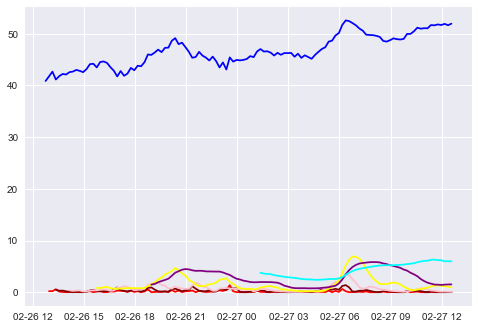

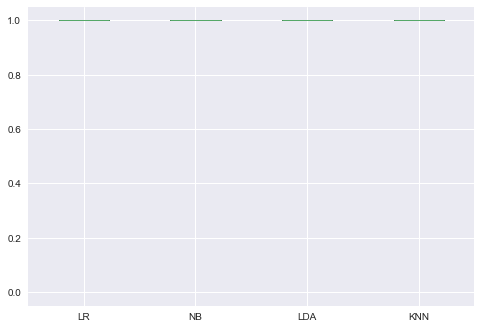

LR: 0.600000 (0.435890) 

NB: 1.000000 (0.000000) 

LDA: 1.000000 (0.000000) 

KNN: 0.950000 (0.150000) 



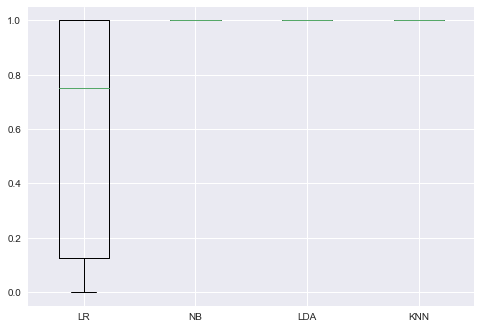

LR: 0.450000 (0.471699) 

NB: 1.000000 (0.000000) 

LDA: 1.000000 (0.000000) 

KNN: 0.850000 (0.320156) 



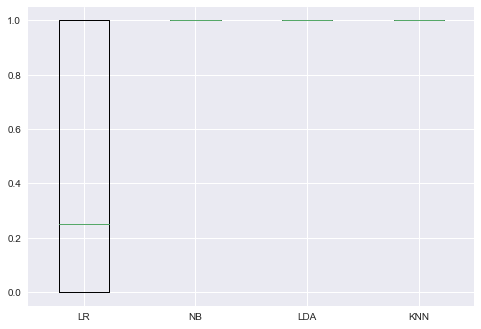

LR: 0.450000 (0.471699) 

NB: 1.000000 (0.000000) 

LDA: 1.000000 (0.000000) 

KNN: 0.850000 (0.229129) 



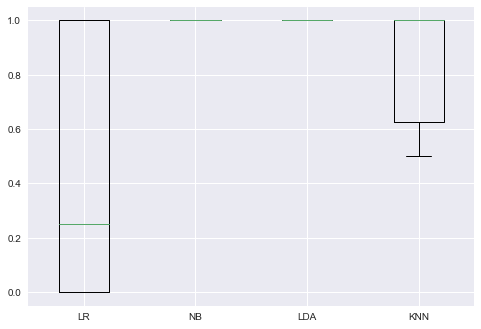

LR: 0.450000 (0.471699) 

NB: 1.000000 (0.000000) 

LDA: 1.000000 (0.000000) 

KNN: 0.900000 (0.300000) 



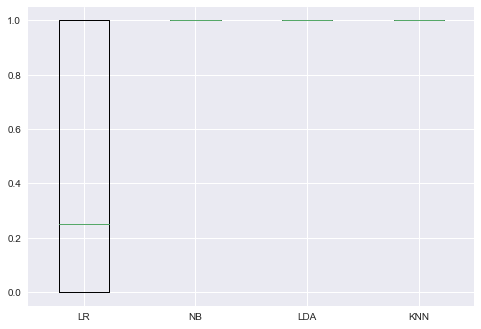

LR: 0.400000 (0.489898) 

NB: 0.900000 (0.300000) 

LDA: 1.000000 (0.000000) 

KNN: 0.950000 (0.150000) 



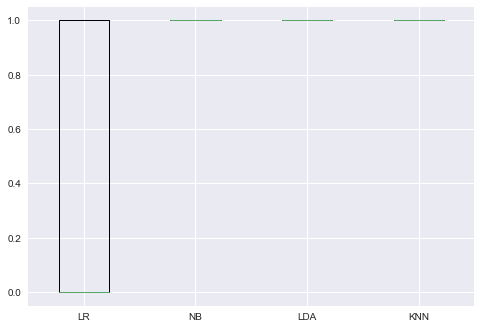

In [55]:
compareAllClf(xI,yI)

LR: 0.661869 (0.278749) 

NB: 0.716313 (0.264650) 

LDA: 0.856162 (0.060733) 

KNN: 0.815455 (0.095661) 



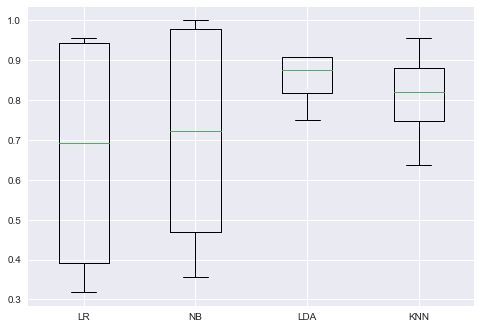

LR: 0.642125 (0.318979) 

NB: 0.691279 (0.292988) 

LDA: 0.873044 (0.060350) 

KNN: 0.819239 (0.077062) 



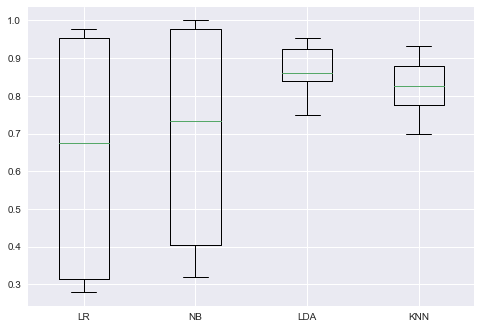

LR: 0.669396 (0.228797) 

NB: 0.709524 (0.276190) 

LDA: 0.856620 (0.051053) 

KNN: 0.844657 (0.055272) 



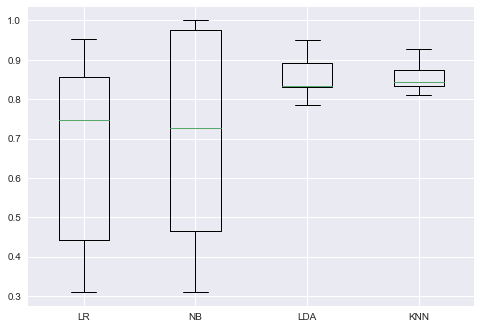

LR: 0.656645 (0.259730) 

NB: 0.620930 (0.373840) 

LDA: 0.859911 (0.050761) 

KNN: 0.855205 (0.045252) 



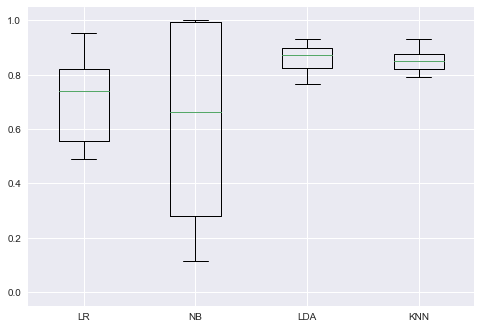

LR: 0.635714 (0.305848) 

NB: 0.714286 (0.276642) 

LDA: 0.819048 (0.063174) 

KNN: 0.864286 (0.028272) 



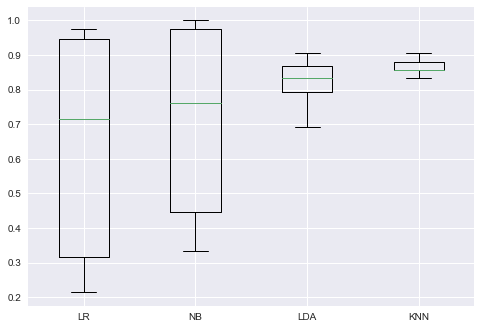

LR: 0.502805 (0.464686) 

NB: 0.762561 (0.231921) 

LDA: 0.820915 (0.081934) 

KNN: 0.865854 (0.042550) 



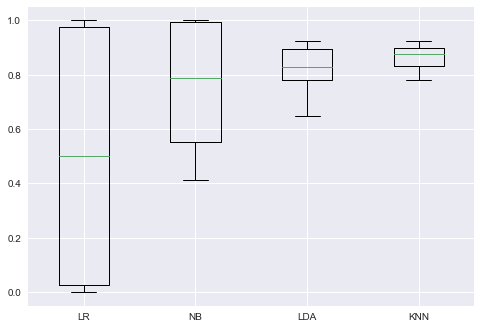

In [56]:
compareAllClf(xII,yII)

LR: 0.651903 (0.292669) 

NB: 0.596353 (0.401144) 

LDA: 0.836152 (0.052841) 

KNN: 0.821987 (0.058906) 



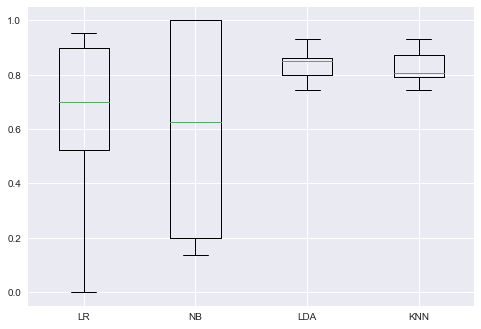

LR: 0.589779 (0.373672) 

NB: 0.716609 (0.272343) 

LDA: 0.872938 (0.062362) 

KNN: 0.829559 (0.057002) 



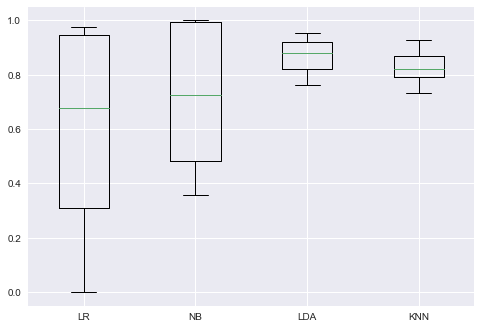

LR: 0.520000 (0.475500) 

NB: 0.770000 (0.208806) 

LDA: 0.872500 (0.071981) 

KNN: 0.842500 (0.067129) 



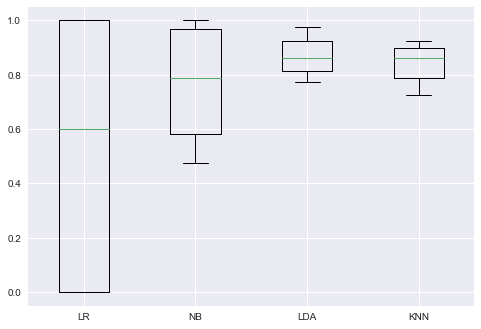

LR: 0.497561 (0.497609) 

NB: 0.765488 (0.202210) 

LDA: 0.818415 (0.063837) 

KNN: 0.808171 (0.049363) 



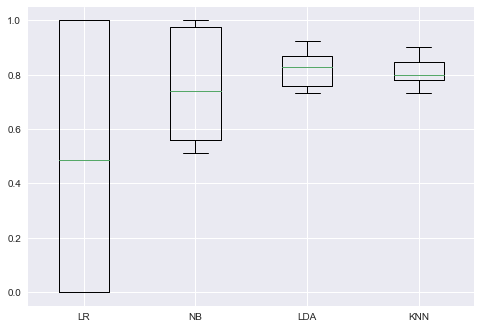

LR: 0.487500 (0.488269) 

NB: 0.793354 (0.192729) 

LDA: 0.800610 (0.096527) 

KNN: 0.840610 (0.063589) 



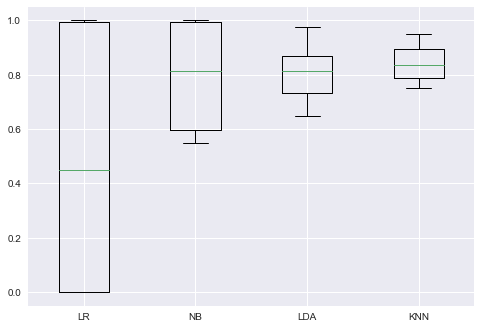

LR: 0.559602 (0.377871) 

NB: 0.734139 (0.260035) 

LDA: 0.859602 (0.071218) 

KNN: 0.872546 (0.059184) 



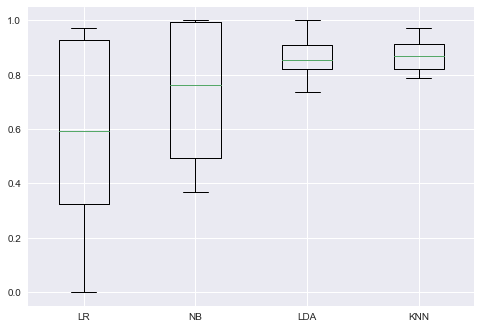

In [57]:
compareAllClf(xIII,yIII)

#### Split test-train in all extraction windows with 40% test data

In [58]:
def trainTestSplit(X,y):
    X.l12_s6.train, X.l12_s6.test, y.l12_s6.train, y.l12_s6.test = train_test_split(X.l12_s6, y.l12_s6, test_size=0.4, random_state=1234)
    X.l12_s12.train, X.l12_s12.test, y.l12_s12.train, y.l12_s12.test = train_test_split(X.l12_s12, y.l12_s12, test_size=0.4, random_state=1234)
    X.l12_s24.train, X.l12_s24.test, y.l12_s24.train, y.l12_s24.test = train_test_split(X.l12_s24, y.l12_s24, test_size=0.4, random_state=1234)
    X.l24_s6.train, X.l24_s6.test, y.l24_s6.train, y.l24_s6.test = train_test_split(X.l24_s6, y.l24_s6, test_size=0.4, random_state=1234)
    X.l24_s12.train, X.l24_s12.test, y.l24_s12.train, y.l24_s12.test = train_test_split(X.l24_s12, y.l24_s12, test_size=0.4, random_state=1234)
    X.l24_s24.train, X.l24_s24.test, y.l24_s24.train, y.l24_s24.test = train_test_split(X.l24_s24, y.l24_s24, test_size=0.4, random_state=1234)
    return X, y

#### GridSearchCV on KNN (k=1:100)

In [59]:
def fitKNN(X_train,y_train):
    cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.4, random_state=0)
    knn=pd.DataFrame()
    knn.classifier = GridSearchCV(KNeighborsClassifier(),{'n_neighbors': arange(100)+1}, cv=cv,scoring='roc_auc')
    knn.classifier.fit(X_train, y_train)
    return knn.classifier

#### GridSearchCV on LDA ('solver': ['svd','lsqr'])

In [60]:
def fitLDA(X_train,y_train):
    cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.4, random_state=0)
    lda=pd.DataFrame()
    lda.parameters = {'solver': ['svd','lsqr']}
    lda.classifier = GridSearchCV(LinearDiscriminantAnalysis(),lda.parameters, cv=cv,scoring='roc_auc')
    lda.classifier.fit(X_train, y_train)
    return lda.classifier

#### Combine both Grids in a soft-voting Ensemble

In [61]:
def fitEnsemble(X,y):
    estimators = []
    estimators.append(('knn', fitKNN(X.train,y.train)))
    estimators.append(('lda', fitLDA(X.train,y.train)))
    ensemble = VotingClassifier(estimators,voting='soft')
    ensemble.fit(X.train, y.train)
    return ensemble

In [62]:
def fitAll(X,y):
    model=pd.DataFrame()
    model.l12_s6=fitEnsemble(X.l12_s6,y.l12_s6)
    model.l12_s12=fitEnsemble(X.l12_s12,y.l12_s12)
    model.l12_s24=fitEnsemble(X.l12_s24,y.l12_s24)
    model.l24_s6=fitEnsemble(X.l24_s6,y.l24_s6)
    model.l24_s12=fitEnsemble(X.l24_s12,y.l24_s12)
    model.l24_s24=fitEnsemble(X.l24_s24,y.l24_s24)
    return model

### Test Train Split

In [63]:
x2,y2=trainTestSplit(xII,yII)
x3,y3=trainTestSplit(xIII,yIII)

In [64]:
model2=fitAll(x2,y2)

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [65]:
model3=fitAll(x3,y3)

In [66]:
color=['Violet','Indigo','Blue','Green','Yellow','Black']
label=['l12_s6','l12_s12','l12_s24','l24_s6','l24_s12','l24_s24']
def plotKNNscores(knn,z):
    bestK=knn.best_estimator_.get_params()['n_neighbors']
    for i, score in enumerate(knn.grid_scores_):
        plt.scatter(i+1,score[1],zorder=z,color=color[z],label=label[z]) 
        if i+1 == bestK:
            plt.scatter(i+1,score[1],zorder=10,color=color[z],label=label[z]+' Best K',marker='*',edgecolor = 'Red')
       

In [67]:
def plotAllKNNScores(model):
    plotKNNscores(model.l12_s6.estimators[0][1],0)
    plotKNNscores(model.l12_s12.estimators[0][1],1)
    plotKNNscores(model.l12_s24.estimators[0][1],2)
    plotKNNscores(model.l24_s6.estimators[0][1],3)
    plotKNNscores(model.l24_s12.estimators[0][1],4)
    plotKNNscores(model.l24_s24.estimators[0][1],5)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = od(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title("Mean CV Score for Grid Search on KNN")
    plt.show()

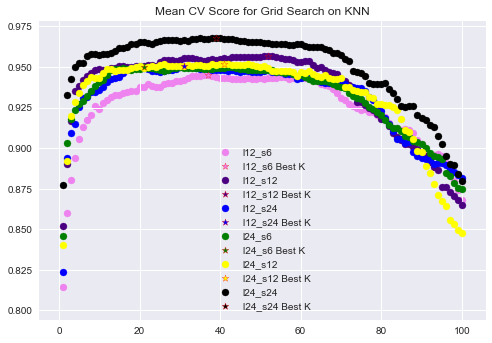

In [68]:
plotAllKNNScores(model2)

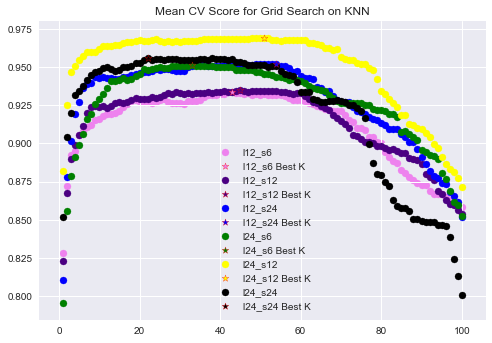

In [69]:
plotAllKNNScores(model3)

In [70]:
def printClfReport(x,y,model):
    print "Train Report"
    print classification_report(y.train, model.predict(x.train), target_names=['noFlare','Flare'])
    print "Test Report"
    print classification_report(y.test, model.predict(x.test), target_names=['noFlare','Flare'])

In [71]:
def printAllClfReport(x,y,model):
    print '\t\t\tl12_s6\n'
    printClfReport(x.l12_s6,y.l12_s6,model.l12_s6)
    print '\t\t\tl12_s12\n'
    printClfReport(x.l12_s12,y.l12_s12,model.l12_s12)
    print '\t\t\tl12_s24\n'
    printClfReport(x.l12_s24,y.l12_s24,model.l12_s24)
    print '\t\t\tl24_s6\n'
    printClfReport(x.l24_s6,y.l24_s6,model.l24_s6)
    print '\t\t\tl24_s12\n'
    printClfReport(x.l24_s12,y.l24_s12,model.l24_s12)
    print '\t\t\tl24_s24\n'
    printClfReport(x.l24_s24,y.l24_s24,model.l24_s24)
    

In [72]:
printAllClfReport(x2,y2,model2)

			l12_s6

Train Report
             precision    recall  f1-score   support

    noFlare       0.95      0.97      0.96       131
      Flare       0.97      0.95      0.96       135

avg / total       0.96      0.96      0.96       266

Test Report
             precision    recall  f1-score   support

    noFlare       0.83      0.95      0.88        91
      Flare       0.93      0.79      0.86        87

avg / total       0.88      0.87      0.87       178

			l12_s12

Train Report
             precision    recall  f1-score   support

    noFlare       0.94      0.97      0.95       125
      Flare       0.97      0.94      0.95       134

avg / total       0.95      0.95      0.95       259

Test Report
             precision    recall  f1-score   support

    noFlare       0.92      0.93      0.93        91
      Flare       0.93      0.91      0.92        82

avg / total       0.92      0.92      0.92       173

			l12_s24

Train Report
             precision    recall  f1-score

In [73]:
printAllClfReport(x3,y3,model3)

			l12_s6

Train Report
             precision    recall  f1-score   support

    noFlare       0.93      0.94      0.94       124
      Flare       0.95      0.93      0.94       135

avg / total       0.94      0.94      0.94       259

Test Report
             precision    recall  f1-score   support

    noFlare       0.89      0.90      0.90        92
      Flare       0.89      0.88      0.88        82

avg / total       0.89      0.89      0.89       174

			l12_s12

Train Report
             precision    recall  f1-score   support

    noFlare       0.92      0.96      0.94       126
      Flare       0.96      0.92      0.94       124

avg / total       0.94      0.94      0.94       250

Test Report
             precision    recall  f1-score   support

    noFlare       0.85      0.96      0.90        82
      Flare       0.96      0.84      0.89        85

avg / total       0.91      0.90      0.90       167

			l12_s24

Train Report
             precision    recall  f1-score

In [74]:
def plotRoc(false_positive_rate, true_positive_rate,roc_auc,color,label,ls):
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color=color,ls=ls,label=label)
    label=label+' AUC = %0.2f'% roc_auc
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [75]:
color=['Violet','Indigo','Blue','Green','Yellow','Black']
label=['l12_s6','l12_s12','l12_s24','l24_s6','l24_s12','l24_s24']
def plotBothROC(X_test,y_test,model,i):
    knn=pd.DataFrame()
    lda=pd.DataFrame()
    knn=model.estimators[0][1].best_estimator_
    lda=model.estimators[1][1].best_estimator_
    
    knn.false_positive_rate, knn.true_positive_rate, knn.thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
    knn.roc_auc = auc(knn.false_positive_rate, knn.true_positive_rate)
    plotRoc(knn.false_positive_rate, knn.true_positive_rate,knn.roc_auc,color[i],label[i]+' KNN',"-")

    lda.false_positive_rate, lda.true_positive_rate, lda.thresholds = roc_curve(y_test, lda.predict_proba(X_test)[:,1])
    lda.roc_auc = auc(lda.false_positive_rate, lda.true_positive_rate)

    plotRoc(lda.false_positive_rate, lda.true_positive_rate,lda.roc_auc,color[i],label[i]+' LDA',"-.")
    plt.legend()

In [76]:
def plotAllROC(X,y,model):
    plotBothROC(X.l12_s6.test,y.l12_s6.test,model.l12_s6,0)
    plotBothROC(X.l12_s12.test,y.l12_s12.test,model.l12_s12,1)
    plotBothROC(X.l12_s24.test,y.l12_s24.test,model.l12_s24,2)
    plotBothROC(X.l24_s6.test,y.l24_s6.test,model.l24_s6,3)
    plotBothROC(X.l24_s12.test,y.l24_s12.test,model.l24_s12,4)
    plotBothROC(X.l24_s24.test,y.l24_s24.test,model.l24_s24,5)

    plt.legend()
    plt.show()

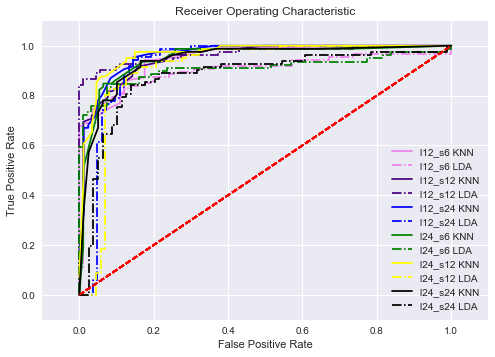

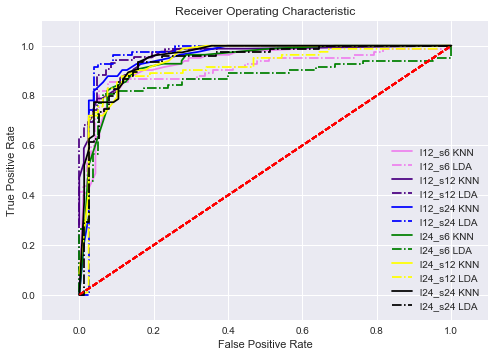

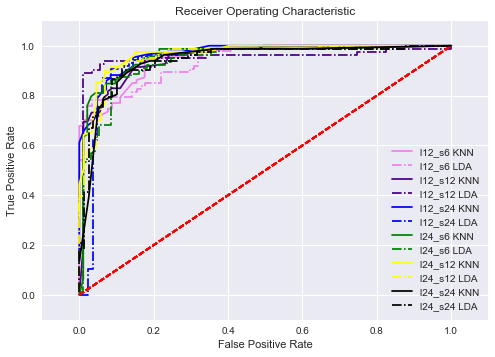

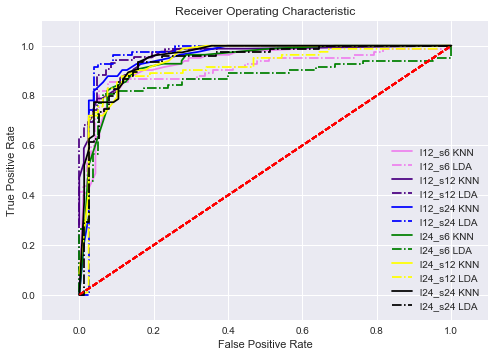

In [77]:
plotAllROC(x2,y2,model2)

plotAllROC(x3,y3,model2)

plotAllROC(x2,y2,model3)

plotAllROC(x3,y3,model2)

### Final Model

##### Fit on Dataset 2 + 3

In [78]:
X=pd.DataFrame()
X.l12_s6=xII.l12_s6.append(xIII.l12_s6)
X.l12_s12=xII.l12_s12.append(xIII.l12_s12)
X.l12_s24=xII.l12_s24.append(xIII.l12_s24)
X.l24_s6=xII.l24_s6.append(xIII.l24_s6)
X.l24_s12=xII.l24_s12.append(xIII.l24_s12)
X.l24_s24=xII.l24_s24.append(xIII.l24_s24)
y=pd.DataFrame()
y.l12_s6=yII.l12_s6.append(yIII.l12_s6)
y.l12_s12=yII.l12_s12.append(yIII.l12_s12)
y.l12_s24=yII.l12_s24.append(yIII.l12_s24)
y.l24_s6=yII.l24_s6.append(yIII.l24_s6)
y.l24_s12=yII.l24_s12.append(yIII.l24_s12)
y.l24_s24=yII.l24_s24.append(yIII.l24_s24)

x,y=trainTestSplit(X,y)


In [79]:
model=fitAll(x,y)

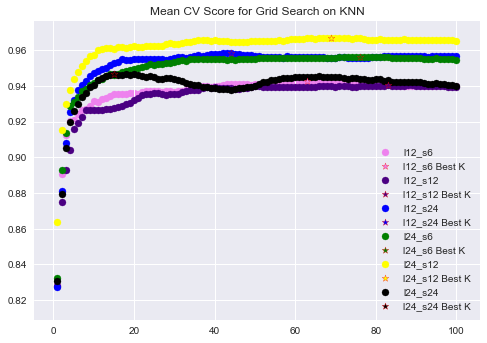

In [80]:
plotAllKNNScores(model)

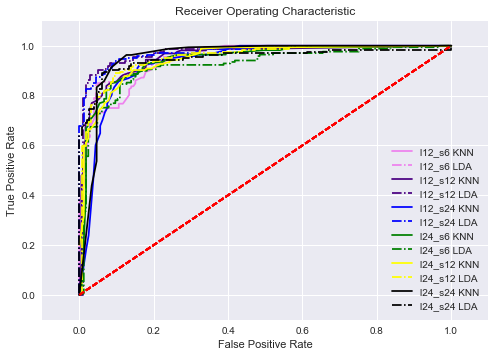

In [81]:
plotAllROC(x,y,model)

In [82]:
printAllClfReport(x,y,model)

			l12_s6

Train Report
             precision    recall  f1-score   support

    noFlare       0.91      0.95      0.93       259
      Flare       0.95      0.91      0.93       267

avg / total       0.93      0.93      0.93       526

Test Report
             precision    recall  f1-score   support

    noFlare       0.91      0.90      0.90       179
      Flare       0.90      0.91      0.90       172

avg / total       0.90      0.90      0.90       351

			l12_s12

Train Report
             precision    recall  f1-score   support

    noFlare       0.93      0.92      0.92       245
      Flare       0.93      0.93      0.93       264

avg / total       0.93      0.93      0.93       509

Test Report
             precision    recall  f1-score   support

    noFlare       0.93      0.95      0.94       179
      Flare       0.94      0.92      0.93       161

avg / total       0.94      0.94      0.94       340

			l12_s24

Train Report
             precision    recall  f1-score

### Final Predictions

In [83]:
def makePredictions(x,model):
    rev_fx = lambda x: 'flare' if x==1 else 'noflare' 
    pred=pd.DataFrame()
    pred.l12_s6=pd.DataFrame(asarray(map(rev_fx, model.l12_s6.predict(x.l12_s6))))
    pred.l12_s6.index=x.l12_s6.index
    pred.l12_s6.columns=['event_type']
    
    pred.l12_s12=pd.DataFrame(asarray(map(rev_fx, model.l12_s12.predict(x.l12_s12))))
    pred.l12_s12.columns=['event_type']
    pred.l12_s12.index=x.l12_s12.index
    
    pred.l12_s24=pd.DataFrame(asarray(map(rev_fx, model.l12_s24.predict(x.l12_s24))))
    pred.l12_s24.columns=['event_type']
    pred.l12_s24.index=x.l12_s24.index
    
    pred.l24_s6=pd.DataFrame(asarray(map(rev_fx, model.l24_s6.predict(x.l24_s6))))
    pred.l24_s6.columns=['event_type']
    pred.l24_s6.index=x.l24_s6.index
    
    pred.l24_s12=pd.DataFrame(asarray(map(rev_fx, model.l24_s12.predict(x.l24_s12))))
    pred.l24_s12.columns=['event_type']
    pred.l24_s12.index=x.l24_s12.index
    
    pred.l24_s24=pd.DataFrame(asarray(map(rev_fx, model.l24_s24.predict(x.l24_s24))))
    pred.l24_s24.columns=['event_type']
    pred.l24_s24.index=x.l24_s24.index
    return pred

In [84]:
pred=makePredictions(xIV,model)

#### Combine All Predictions

In [85]:
allPreds = pred.l12_s6.append(pred.l12_s12).append(pred.l12_s24).append(pred.l24_s6).append(pred.l24_s12).append(pred.l24_s24)

#### Sort Predictions

In [86]:
allPreds.sort_index(inplace=True)

#### Write Prediction to disk as a CSV File

In [87]:
allPreds.to_csv('out.csv')